# <center>Modeling</center>

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score,confusion_matrix
import keras_tuner as kt
import cv2
import imutils

# Load the saved dataset

When loaded, images are resized to 125x125 and normalized to [0,1].

In [2]:
def parse_example(serialized_example):
    
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }

    
    parsed_example = tf.io.parse_single_example(serialized_example, feature_description)
    
    
    image = tf.io.decode_jpeg(parsed_example['image'], channels=3)
    label = parsed_example['label']
    
    
    image = tf.image.resize(image, [125, 125])  
      
    
    return image, label


#load the training dataset
train_dataset = tf.data.TFRecordDataset('../data/interim/train_data.tfrecord')
train_dataset = train_dataset.map(parse_example)

#load the test dataset
test_dataset = tf.data.TFRecordDataset('../data/interim/test_data.tfrecord')
test_dataset = test_dataset.map(parse_example)


## Preprocessing

The first step in preprocessing is to encode the labels, we group the dataset into batches and shuffle the data to mix the batches to avoid overfitting.

In [3]:

def preprocess_labels(image, label):
    label = tf.one_hot(label, depth=4)  
    return image, label

def preprocess_dataset(dataset, batch_size=32):
    dataset = dataset.shuffle(1000)  
    dataset = dataset.batch(batch_size)  
    dataset = dataset.prefetch(tf.data.AUTOTUNE)  
    return dataset

In [4]:
train_dataset = train_dataset.map(preprocess_labels)
train_dataset = preprocess_dataset(train_dataset)

test_dataset = test_dataset.map(preprocess_labels)
test_dataset = preprocess_dataset(test_dataset)


We then crop the images to help focus on the brain area, removing unnecessary background, before cropping, a 5x5 gaussian filter was applied to remove noise.

In [5]:
def crop_image(img):

    img = img.numpy().astype("uint8")
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

	
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    ADD_PIXELS = 0
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
    resized_img = cv2.resize(new_img, [125,125])
    return resized_img

Additionaly, we define a function to enhance the contrast of images

In [6]:
def enhance_contrast(image, contrast_factor=1.5):
    image = tf.image.adjust_contrast(image, contrast_factor)
    return image

Let's visualize a sample of images before and after cropping and contrst enhancement.

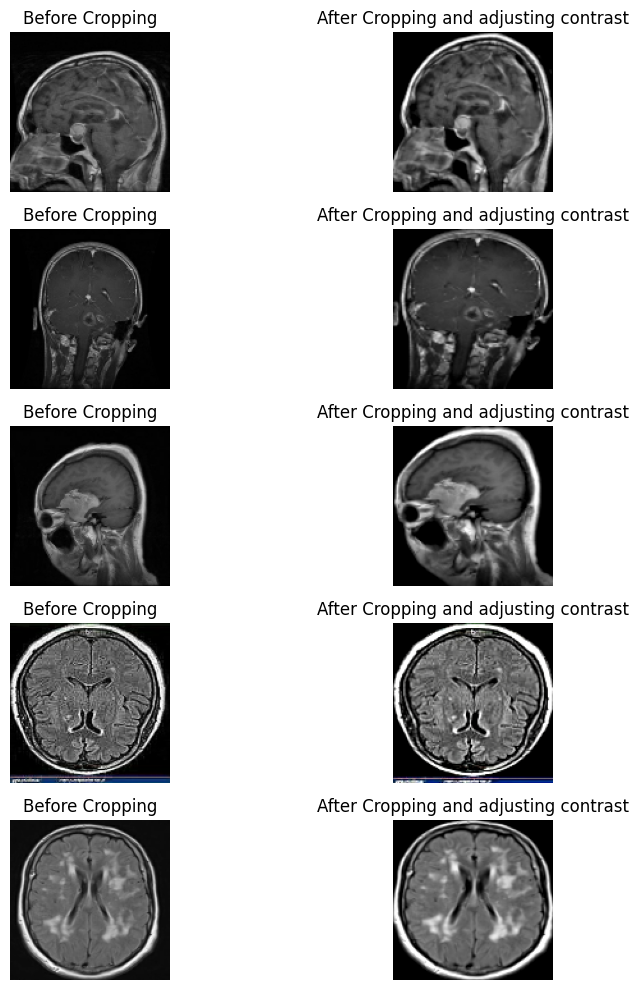

In [7]:
sample_batch = next(iter(train_dataset.take(1)))  

images, labels = sample_batch

num_images_to_show = 5
fig, axes = plt.subplots(num_images_to_show, 2, figsize=(10, 10))

for i in range(num_images_to_show):
    ax_before, ax_after = axes[i]
    
    # Get the image from the batch
    #image = (images[i]*255).numpy().astype("uint8") 
    
    cropped_image = enhance_contrast(crop_image(images[i]))/255
    
    # Plot before cropping
    ax_before.imshow(images[i]/255)
    ax_before.set_title("Before Cropping")
    ax_before.axis('off')
    
    # Plot after cropping
    ax_after.imshow(cropped_image)
    ax_after.set_title("After Cropping and adjusting contrast")
    ax_after.axis('off')

plt.tight_layout()
plt.show()

We save the preprocessed data into a tfrecord filename.

In [9]:
def image_to_example(image, label):
    img_raw = tf.io.encode_jpeg(tf.cast(image*255, tf.uint8)).numpy()
    
    feature = {
        'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_raw])),
        'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))
    }
    
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    return example


def write_cropped_to_tfrecord(dataset, tfrecord_filename):
    with tf.io.TFRecordWriter(tfrecord_filename) as writer:
        for batch_images, batch_labels in dataset:
            batch_labels = tf.argmax(batch_labels, axis=1)  
            
            
            batch_images = tf.map_fn(lambda x: enhance_contrast(crop_image(x))/255, batch_images)

            
            for img, label in zip(batch_images, batch_labels):
                example = image_to_example(img, label.numpy())
                writer.write(example.SerializeToString())


write_cropped_to_tfrecord(train_dataset, '../data/processed/cropped_train_data.tfrecord')

Now, we load the preprocessed data into a new dataset.

In [12]:
def rescale_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label
    
#load the processed training dataset
train_dataset_proc = tf.data.TFRecordDataset('../data/processed/cropped_train_data.tfrecord')
train_dataset_proc = train_dataset_proc.map(parse_example)
train_dataset_proc = train_dataset_proc.map(preprocess_labels)
train_dataset_proc = train_dataset_proc.map(rescale_image)
train_dataset_proc = preprocess_dataset(train_dataset_proc)

Let's visualize a sample of images from the preprocessed dataset.

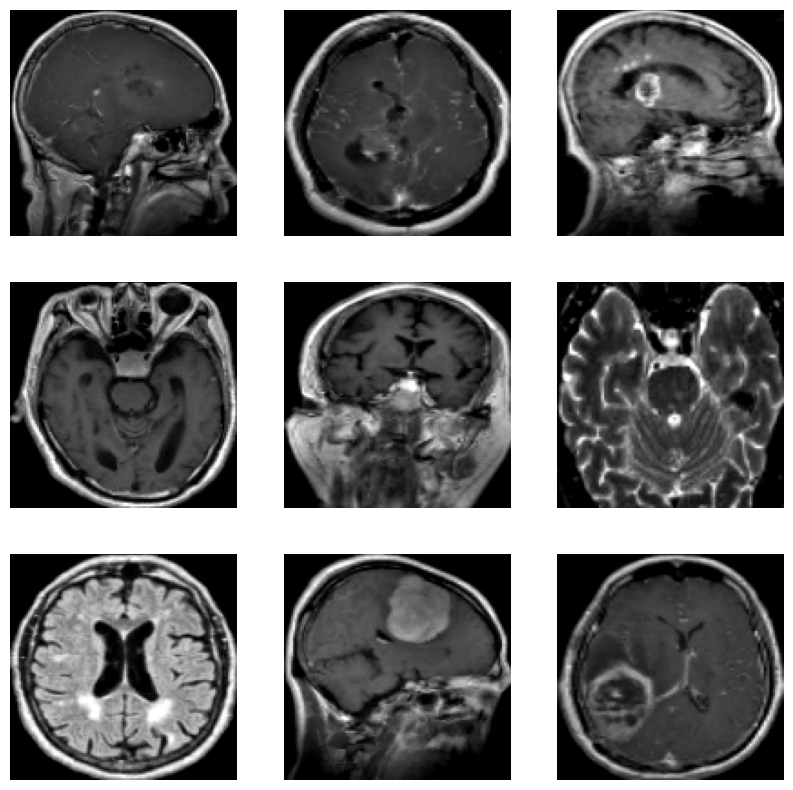

In [13]:
image_batch, label_batch = next(iter(train_dataset_proc))
#image_batch = image_batch/255
plt.figure(figsize=(10, 10))
for i in range(min(9, len(image_batch))):  
    plt.subplot(3, 3, i+1)  
    plt.imshow(image_batch[i].numpy())  
    #plt.title(class_names[tf.argmax(label_batch[i]).numpy()])  
    plt.axis('off')
plt.show()

## Modeling
Let's start with building the model.

In [14]:
def build_cnn_model(input_shape=(125, 125, 3), num_classes=4):
    
    model = models.Sequential()
    
    model.add(layers.InputLayer(shape=input_shape))
    model.add(layers.Conv2D(32, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(64, (5, 5), activation='relu',kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (7, 7), activation='relu',kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model


To train the model, we apply cross validation and split the dataset into 5 folds.

In [15]:
images = []
labels = []

for image, label in train_dataset_proc:
    label = np.argmax(label, axis=1)
    for i in range(image.shape[0]):  
            images.append(image[i])  
            labels.append(label.tolist()[i]) 

images = np.array(images)
labels = np.array(labels)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) 


In [16]:
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []



for train_index, val_index in kf.split(images, labels):
    # Split the data into train and validation sets
    X_train, X_val = images[train_index], images[val_index]
    y_train, y_val = labels[train_index], labels[val_index]
    
    model = build_cnn_model(input_shape=(125, 125, 3), num_classes=4)
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    
    history = model.fit(X_train, y_train, epochs=25, batch_size=32,validation_data=(X_val, y_val), verbose=1) 
    
    
    train_accuracies.append(history.history['accuracy'])
    val_accuracies.append(history.history['val_accuracy'])
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])

# Compute the average accuracy and loss over all folds
average_accuracy = np.mean(val_accuracies)
average_loss = np.mean(val_losses)

print(f"Average Accuracy: {average_accuracy:.4f}")
print(f"Average Loss: {average_loss:.4f}")

Epoch 1/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 47s 323ms/step - accuracy: 0.3444 - loss: 2.0528 - val_accuracy: 0.5293 - val_loss: 1.1493
Epoch 2/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 49s 344ms/step - accuracy: 0.6269 - loss: 1.0365 - val_accuracy: 0.7060 - val_loss: 0.9000
Epoch 3/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 53s 370ms/step - accuracy: 0.7089 - loss: 0.8589 - val_accuracy: 0.7480 - val_loss: 0.7204
Epoch 4/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 80s 353ms/step - accuracy: 0.7713 - loss: 0.7165 - val_accuracy: 0.8311 - val_loss: 0.6091
Epoch 5/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 58s 404ms/step - accuracy: 0.8069 - loss: 0.6406 - val_accuracy: 0.8373 - val_loss: 0.5564
Epoch 6/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 57s 399ms/step - accuracy: 0.8040 - loss: 0.6117 - val_accuracy: 0.8224 - val_loss: 0.5917
Epoch 7/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 57s 397ms/step - accuracy: 0.8409 - loss: 0.5621 - val_accuracy: 0.8635 - val_loss: 0.4969
Epoch 8/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 58s 408ms/step - accuracy: 0.8513 - loss: 0

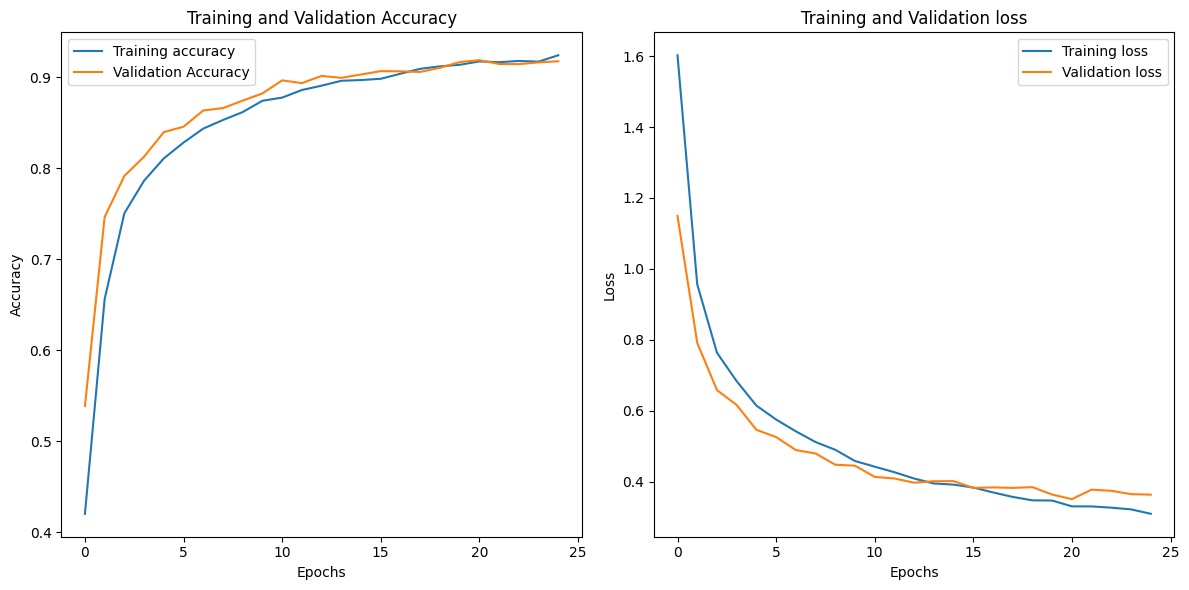

In [18]:

import matplotlib.pyplot as plt



mean_train_accuracies = np.mean(np.array(train_accuracies),axis=0)
mean_val_accuracies = np.mean(np.array(val_accuracies),axis=0)
mean_train_losses = np.mean(np.array(train_losses),axis=0)
mean_val_losses = np.mean(np.array(val_losses),axis=0)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.epoch, mean_train_accuracies,label='Training accuracy')
plt.plot(history.epoch, mean_val_accuracies,label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.epoch, mean_train_losses,label='Training loss')
plt.plot(history.epoch, mean_val_losses,label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Here we can see the impact of Dropout and L2 regularization, they tend to slightly reduce training accuracy because they intentionally limit the model's capacity during training. However, they help the model generalize better, which improve validation accuracy. Hence, we can see a higher validation accuracy due to the regularization helping avoid overfitting.
After training, we can evaluate the model on the test set, we apply the same preprocessing to the test set as the training set and we save the data.

In [30]:
write_cropped_to_tfrecord(test_dataset, '../data/processed/cropped_test_data.tfrecord')

Next, we load the saved test set and compute the accuracy.

In [31]:
test_dataset_proc = tf.data.TFRecordDataset('../data/processed/cropped_test_data.tfrecord')
test_dataset_proc = test_dataset_proc.map(parse_example)
test_dataset_proc = test_dataset_proc.map(rescale_image)
test_dataset_proc = preprocess_dataset(test_dataset_proc)
#test_dataset_proc = test_dataset_proc.map(preprocess_labels)

In [33]:
test_loss, test_accuracy = model.evaluate(test_dataset_proc,steps=1311//32)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.9243 - loss: 0.3431
Test Loss: 0.33943164348602295
Test Accuracy: 0.91796875


## Hyperparameter tuning
We propose in the folowing to train and tune our model using Keras Tuner while also applying cross-validation.
### Stratified K-Fold Cross-Validation

In [61]:
images = []
labels = []

for image, label in train_dataset_proc:
    label = np.argmax(label, axis=1)
    for i in range(image.shape[0]):  
            images.append(image[i])  
            labels.append(label.tolist()[i]) 

images = np.array(images)
labels = np.array(labels)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Define the Hypermodel with Keras Tuner

In [62]:
def build_model(hp,num_classes=4):
    model = models.Sequential()

    
    model.add(layers.InputLayer(shape=(125, 125, 3)))
    
    
    model.add(layers.Conv2D(hp.Int('filters_1', min_value=32, max_value=128, step=32), (3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))
   
    model.add(layers.Conv2D(hp.Int('filters_2', min_value=64, max_value=256, step=64), (5, 5), activation='relu',kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))
   
    model.add(layers.Conv2D(hp.Int('filters_3', min_value=128, max_value=512, step=128), (7, 7), activation='relu',kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(hp.Int('dense_units', min_value=64, max_value=256, step=64), activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))  

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=0.1, sampling='log')),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

Next, we will split the data into training and validation sets within each fold and use Keras Tuner to tune the hyperparameters for each fold.

In [64]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    directory='../models',
    project_name='Brain_Tumor_classification'
)

cv_results = []


for fold, (train_index, val_index) in enumerate(kf.split(images, labels), 1):
    print(f"Training fold {fold}...")

    
    X_train, X_val = images[train_index], images[val_index]
    y_train, y_val = labels[train_index], labels[val_index]

    tuner.search(X_train,y_train, epochs=10, validation_data=(X_val,y_val))

    
    best_model = tuner.get_best_models(num_models=1)[0]

   
    val_loss, val_accuracy = best_model.evaluate(x=X_val,y=y_val)
    print(f"Validation accuracy for fold {fold}: {val_accuracy}")

    
    cv_results.append(val_accuracy)


mean_val_accuracy = np.mean(cv_results)
std_val_accuracy = np.std(cv_results)

print(f"Mean validation accuracy across folds: {mean_val_accuracy}")
print(f"Standard deviation of validation accuracy across folds: {std_val_accuracy}")


Trial 20 Complete [01h 29m 24s]
val_accuracy: 0.27909010648727417

Best val_accuracy So Far: 0.927384078502655
Total elapsed time: 18h 54m 29s


C:\Users\sabra\anaconda3\envs\cap3\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 335ms/step - accuracy: 0.9329 - loss: 0.3950
Validation accuracy for fold 1: 0.927384078502655
Training fold 2...
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 315ms/step - accuracy: 0.9641 - loss: 0.3324
Validation accuracy for fold 2: 0.9562554955482483
Training fold 3...
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 316ms/step - accuracy: 0.9662 - loss: 0.3449
Validation accuracy for fold 3: 0.9614710807800293
Training fold 4...
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 316ms/step - accuracy: 0.9648 - loss: 0.3312
Validation accuracy for fold 4: 0.9614710807800293
Training fold 5...
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 305ms/step - accuracy: 0.9652 - loss: 0.3342
Validation accuracy for fold 5: 0.960595428943634
Mean validation accuracy across folds: 0.9534354329109191
Standard deviation of validation accuracy across folds: 0.013168406405671143


In [65]:
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
print(best_trial.hyperparameters.values)

{'filters_1': 64, 'filters_2': 64, 'filters_3': 512, 'dense_units': 256, 'learning_rate': 0.00022146929820420383}


### Evaluate the best model

Let's evaluate the best model on the test dataset.

In [66]:

test_loss, test_accuracy = best_model.evaluate(test_dataset_proc,steps=1311//32)
print(f"Test Accuracy: {test_accuracy}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 245ms/step - accuracy: 0.9178 - loss: 0.4201
Test Accuracy: 0.913281261920929


Next, We compute the precision, recall, F1 score, the roc auc score and the confusion matrix, these metrics are computed using the marco average, means they are calculated for each class, then the unweighted average is taken. 

In [78]:
predictions = best_model.predict(test_dataset_proc)
predicted_labels = np.argmax(predictions, axis=-1)  

41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 255ms/step


In [80]:
test_labels = []
for image, label in test_dataset_proc:
    #label = np.argmax(label, axis=1)
    for i in range(image.shape[0]): 
        test_labels.append(label[i]) 

test_labels = np.array(test_labels)

precision = precision_score(test_labels, predicted_labels, average='macro', labels=np.unique(predicted_labels))
recall = recall_score(test_labels, predicted_labels, average='macro', labels=np.unique(predicted_labels))
f1 = f1_score(test_labels, predicted_labels, average='macro', labels=np.unique(predicted_labels))


roc_auc = roc_auc_score(test_labels, predictions, multi_class='ovr', average='macro')


cm = confusion_matrix(test_labels, predicted_labels)

Precision : 0.2722810687752296
Recall : 0.27217501815541034
F1-Score : 0.2720421175437851
AUC-ROC : 0.5046529066748671


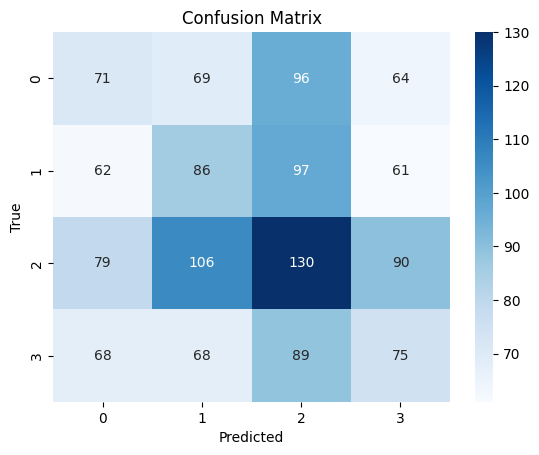

In [81]:
print(f"Precision : {precision}")
print(f"Recall : {recall}")
print(f"F1-Score : {f1}")
print(f"AUC-ROC : {roc_auc}")


sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(predicted_labels), yticklabels=np.unique(predicted_labels))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Given that brain tumor classification typically involves detecting a serious medical condition, we need to ensure that the model is both accurate and reliable, particularly in detecting tumors and minimizing false negatives. The most important metric in this context is recall as false negatives (failing to identify a tumor) are much more dangerous than false positives (incorrectly identifying a tumor). The proposed model achieves a high accuracy rate but fails to minimize the false negative rate. To address this issue, we can:

- Use data augmentation techniques to generate more data which can help the model generalize better and improve its ability to detect positive cases.
- Increase model complexity, either by adding more layers or more neurons in the dense layers which can help the model learn better feature representations.
- Tune more hyperparameters like batch size and dropout rate to explore different configurations and select the one that works best for improving recall.